# Training a CNN

Used this blog as a starting point:

http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/

# Lots of imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm     as cm
import matplotlib.image  as mpimg
%matplotlib inline  

from urllib import urlretrieve

import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using gpu device 0: NVIDIA Tegra X1 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarn

# Define our dataset loading function

The dataset is just a set of images stored in a shallow tree, with the directory signifying the class of the image. The images should all be normalized, using the code in the 'Image normalization' workbook.

In [2]:
def load_dataset(base_path):
    X            = []
    y            = []
    class_labels = {}
    
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            file_path  = os.path.join(subdir, file)
            image      = mpimg.imread(file_path).astype(np.float32)
            class_name = os.path.dirname(file_path).replace(base_path, '', 1)
            
            if not class_name in class_labels:
                class_labels[class_name] = len(class_labels)
                
            X.append(np.asarray(image))
            y.append(class_labels[class_name])
    
    class_labels_inverted = {v: k for k, v in class_labels.iteritems()}

    X = np.array(X).transpose((0,3,1,2))
    y = np.array(y)
    return X, y, class_labels_inverted

In [3]:
def split_dataset(X, y):
    indices = np.random.permutation(len(y))
    training_idx, test_idx = indices[:int(len(y) * 0.8)], indices[int(len(y) * 0.8):]
    
    X_train, y_train = X[training_idx], y[training_idx].astype(np.int32)
    X_test,  y_test  = X[test_idx],     y[test_idx].astype(np.int32)

    return X_train, y_train, X_test, y_test

Load our dataset and inspect it

In [4]:
X, y, class_labels = load_dataset("images.reduced/")

In [5]:
X_train, y_train, X_test, y_test = split_dataset(X, y)

In [6]:
class_labels

{0: 'bert',
 1: 'kermit_the_frog',
 2: 'oscar_the_grouch',
 3: 'rizzo_the_rat',
 4: 'grover',
 5: 'fozzie_bear',
 6: 'swedish_chef',
 7: 'gonzo',
 8: 'cookie_monster',
 9: 'ernie',
 10: 'big_bird',
 11: 'scooter',
 12: 'elmo',
 13: 'beaker',
 14: 'rowlf_the_dog',
 15: 'count',
 16: 'miss_piggy',
 17: 'animal'}

In [7]:
X_train.shape

(508, 3, 128, 128)

In [8]:
y_train.shape

(508,)

# ConvNet Architecture and Training

Now we can define our ConvNet architecture and then train it using a GPU/CPU (I have a very cheap GPU, but it helps a lot):

In [9]:
net1 = NeuralNet(
    layers=[('input',    layers.InputLayer),
            ('conv2d1a', layers.Conv2DLayer),
            ('conv2d1b', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2a', layers.Conv2DLayer),
            ('conv2d2b', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense1',   layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('dense2',   layers.DenseLayer),
            ('dropout3', layers.DropoutLayer),
            ('output',   layers.DenseLayer),
            ],
    
    # input layer
    input_shape=(None, 3, 128, 128),
    
    # layer conv2d1a
    conv2d1a_num_filters=32,
    conv2d1a_filter_size=(3, 3),
    conv2d1a_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1a_W=lasagne.init.GlorotUniform(),    
    
    # layer conv2d1b
    conv2d1b_num_filters=32,
    conv2d1b_filter_size=(3, 3),
    conv2d1b_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1b_W=lasagne.init.GlorotUniform(),    
    
    # layer maxpool1
    maxpool1_pool_size=(2, 2),  
    
    # layer conv2d2a
    conv2d2a_num_filters=24,
    conv2d2a_filter_size=(3, 3),
    conv2d2a_nonlinearity=lasagne.nonlinearities.rectify,
    
    # layer conv2d2b
    conv2d2b_num_filters=24,
    conv2d2b_filter_size=(3, 3),
    conv2d2b_nonlinearity=lasagne.nonlinearities.rectify,
    
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    
    # dropout1
    dropout1_p=0.5,    
    
    # dense1
    dense1_num_units=256,
    dense1_nonlinearity=lasagne.nonlinearities.rectify,    
    
    # dropout2
    dropout2_p=0.5,   
    
    # dense2
    dense2_num_units=128,
    dense2_nonlinearity=lasagne.nonlinearities.rectify,    
    
    # dropout3
    dropout3_p=0.5,   
 
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=28,
    
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=100,
    verbose=1,
    )

# Train the network
nn = net1.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
WARNING (theano.gof.cmodule): OPTIMIZATION WARNING: Theano was not able to find the default g++ parameters. This is needed to tune the compilation to your specific CPU. This can slow down the execution of Theano functions. Please submit the following lines to Theano's mailing list so that we can fix this problem:
 ['# 1 "<stdin>"\n', '# 1 "<built-in>"\n', '# 1 "<command-line>"\n', '# 1 "/usr/include/stdc-predef.h" 1 3 4\n', '# 1 "<command-line>" 2\n', '# 1 "<stdin>"\n', 'Using built-in specs.\n', 'COLLECT_GCC=/usr/bin/g++\n', 'Target: aarch64-linux-gnu\n', "Configured with: ../src/configure -v --with-pkgversion='Ubuntu/Linaro 5.4.0-6ubuntu1~16.04.4' --with-bugurl=file:///usr/share/doc/gcc-5/README.Bugs --enable-languages=c,ada,c++,java,go,d,fortran,objc,obj-c++ --prefix=

# Neural Network with 5226156 learnable parameters

## Layer information

  #  name      size
---  --------  ----------
  0  input     3x128x128
  1  conv2d1a  32x126x126
  2  conv2d1b  32x124x124
  3  maxpool1  32x62x62
  4  conv2d2a  24x60x60
  5  conv2d2b  24x58x58
  6  maxpool2  24x29x29
  7  dropout1  24x29x29
  8  dense1    256
  9  dropout2  256
 10  dense2    128
 11  dropout3  128
 12  output    28

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     3.35407     3.30422    1.01509      0.02804  7.00s
      2     3.28501     3.24379    1.01271      0.08411  6.75s
      3     3.26561     3.17767    1.02767      0.08411  6.78s
      4     3.22844     3.14259    1.02732      0.08411  6.77s
      5     3.18497     3.11971    1.02092      0.08411  6.78s
      6     3.14643     3.09877    1.01538      0.08411  6.81s
      7     3.13939     3.07989    1.01932      0.08411  6.79s
      8     3.14195    

# Prediction and Confusion Matrix

Now we can use the model to predict the entire testing dataset:



In [10]:
preds = net1.predict(X_test)

And we can also plot a confusion matrix to check the performance of the neural network classification:

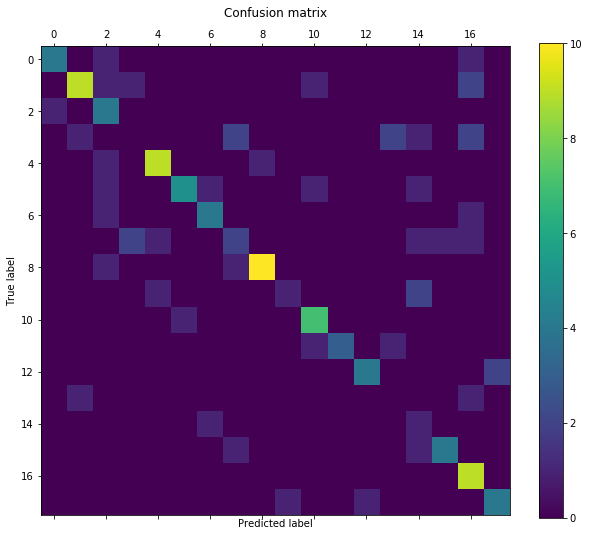

In [11]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig = plt.gcf()
fig.set_size_inches(10.5, 8.5)
plt.show()

# Filters Visualization

We can also visualize the 32 filters from the first convolutional layer:

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

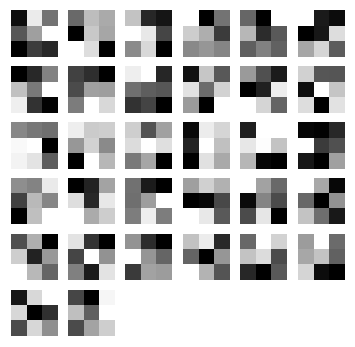

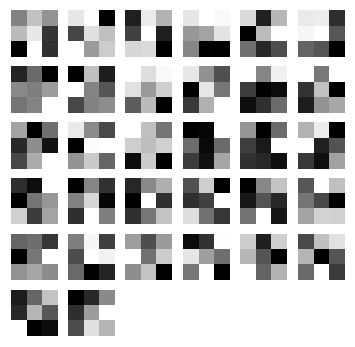

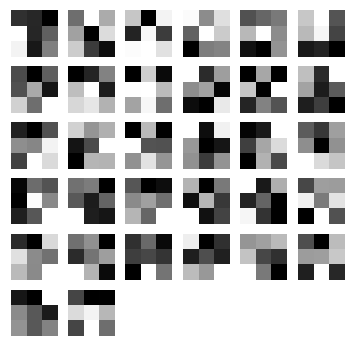

In [12]:
visualize.plot_conv_weights(net1.layers_['conv2d1a'])

# Theano layer functions and Feature Extraction

Now it is time to create theano-compiled functions that will feed-forward the input data into the architecture up to the layer you’re interested. I’m going to get the functions for the output layer and also for the dense layer before the output layer:

In [13]:
dense_layer = layers.get_output(net1.layers_['dense1'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

As you can see, we have now two theano functions called f_output and f_dense (for the output and dense layers). Please note that in order to get the layers here we are using a extra parameter called “deterministic“, this is to avoid the dropout layers affecting our feed-forward pass.

We can now convert an example instance to the input format and then feed it into the theano function for the output layer:

In [14]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)

500 loops, best of 3: 20 ms per loop


We can also plot the output layer activations for the instance:

<Container object of 28 artists>

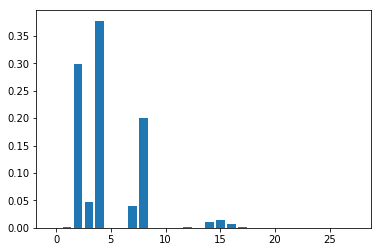

In [15]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

<Container object of 256 artists>

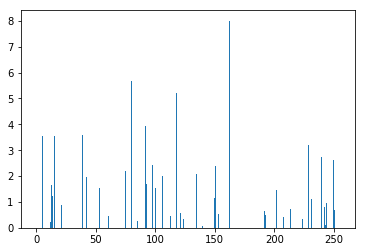

In [16]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

You can now use the output of the these 256 activations as features on a linear classifier like Logistic Regression or SVM.